In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. 회귀란 데이터를 통한 다음 데이터를 예측하기 위해 사용하는 기법입니다. 데이터셋은 통계청에서 사망원인통계 자료를 이용해서 남성의 사망률을 예측합니다.

링크
https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B34E07&vw_cd=MT_ZTITLE&list_id=F_27&scrId=&seqNo=&lang_mode=ko&obj_var_id=&itm_id=&conn_path=MT_ZTITLE&path=%252FstatisticsList%252FstatisticsListIndex.do

여기 입니다.


In [2]:
# csv 파일 읽기
df = pd.read_csv("data.csv")

In [27]:
from sklearn.preprocessing import StandardScaler 

# 연도와 남성 10만명당 사망률을 numpy array로 생성
year = np.array(df[["시점"]]).astype(float)
men = np.array(df[["남자"]]).astype(float)

# 범위 학습
scaler = StandardScaler()
scaler.fit(year)

# 학습된 범위로 변환
trans_year = scaler.transform(year)
trans_men = scaler.transform(men)

# loss 비교를 위한 배열
linear_loss = []
deep_loss = []

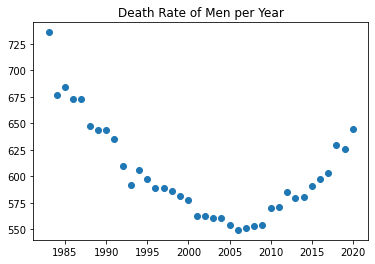

In [4]:
# 통계 자료 그래프로 출력
plt.plot(year, men, 'o')
plt.title("Death Rate of Men per Year")
plt.show()

2. Linear Regression Model

In [28]:
# Linear Regression 실시

W = 0.0
b = 0.0

year_data = len(year)

men_data = len(men)

# 반복횟수와 학습률 설정
epochs = 5000
learning_rate = 0.001

for i in range(epochs):
    hypothesis = trans_year * W + b
    # MSE 계산
    loss = np.sum((hypothesis - trans_men) ** 2) / year_data
    # 목적 함수인 W에 대하여 편미분
    gradient_w = np.sum((W * trans_year - trans_men + b) * 2 * trans_year) / year_data
    # b에 대하여 편미분
    gradient_b = np.sum((W * trans_year - trans_men + b) * 2) / year_data

    # W, b 업데이트
    W -= learning_rate * gradient_w
    b -= learning_rate * gradient_b

    # 100번째 반복마다 loss, W, b 출력
    if i % 100 == 0:
        print('Epoch ({:10d}/{:10d}) loss: {:10f}, W: {:10f}, b:{:10f}'.format(i, epochs, loss, W, b))
        linear_loss.append(loss)

print('W: {:10f}'.format(W))
print('b: {:10f}'.format(b))
print('result : ')
print(year * W + b)


Epoch (         0/      5000) loss: 16273.176855, W:  -0.004482, b: -0.255006
Epoch (       100/      5000) loss: 10907.548861, W:  -0.410227, b:-23.342006
Epoch (       200/      5000) loss: 7312.301165, W:  -0.742356, b:-42.240258
Epoch (       300/      5000) loss: 4903.299644, W:  -1.014226, b:-57.709740
Epoch (       400/      5000) loss: 3289.144288, W:  -1.236770, b:-70.372544
Epoch (       500/      5000) loss: 2207.576886, W:  -1.418937, b:-80.737895
Epoch (       600/      5000) loss: 1482.870904, W:  -1.568053, b:-89.222628
Epoch (       700/      5000) loss: 997.280490, W:  -1.690114, b:-96.167948
Epoch (       800/      5000) loss: 671.909851, W:  -1.790029, b:-101.853157
Epoch (       900/      5000) loss: 453.894728, W:  -1.871817, b:-106.506880
Epoch (      1000/      5000) loss: 307.813344, W:  -1.938765, b:-110.316263
Epoch (      1100/      5000) loss: 209.931276, W:  -1.993567, b:-113.434498
Epoch (      1200/      5000) loss: 144.345239, W:  -2.038426, b:-115.98698

3. Deep Learning 기반의 Regression

In [7]:
# Deep Learning Regression 실시

import tensorflow as tf
from tensorflow import keras
from keras import layers

# 데이터 셋을 훈련 데이터와 테스트 데이터로 분할
dataset = df
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [8]:
# 통계 확인용
train_stats_men = train_dataset.describe()
train_stats_men.pop("남자")
train_stats_men = train_stats_men.transpose()

In [9]:
# 특성에서 레이블 분리
train_labels_men = train_dataset.pop('남자')
test_labels_men = test_dataset.pop('남자')

In [10]:
# 데이터 정규화
def norm_men(x):
  return (x - train_stats_men['mean']) / train_stats_men['std']

normed_train_data_men = norm_men(train_dataset)
normed_test_data_men = norm_men(test_dataset)

In [11]:
# 시퀀스 모델 생성 함수
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [12]:
# 모델 생성
model = build_model()

In [13]:
# 반복 횟수 설정
EPOCHS = 5000

# 모델 훈련
history_men = model.fit(
  normed_train_data_men, train_labels_men,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

In [19]:
# 결과 예측
example_batch = normed_train_data_men[:10]
example_result = model.predict(example_batch)
example_result

array([[553.962  ],
       [578.25   ],
       [584.71136],
       [584.6802 ],
       [603.3247 ],
       [563.80945],
       [557.8717 ],
       [597.6959 ],
       [554.3234 ],
       [685.78174]], dtype=float32)

In [29]:
# 모델 훈련과정 시각화
h = pd.DataFrame(history_men.history)
h['epoch'] = history_men.epoch

for i in range(5000):
  if i % 100 == 0:
    deep_loss.append(h.loc[i]['loss'])

4. linear regression과 deep learning 기반의 regression의 loss 값 비교

In [31]:
for i in range(len(deep_loss)):
  print('['+str(i)+']' + ' linear regression loss: ' + str(linear_loss[i]))
  print('['+str(i)+']' + ' deep learning regression loss: ' + str(deep_loss[i]))

[0] linear regression loss: 16273.176855235804
[0] deep learning regression loss: 357887.28125
[1] linear regression loss: 10907.548861016361
[1] deep learning regression loss: 338213.625
[2] linear regression loss: 7312.301164772789
[2] deep learning regression loss: 286083.21875
[3] linear regression loss: 4903.299644117594
[3] deep learning regression loss: 202291.921875
[4] linear regression loss: 3289.1442877057125
[4] deep learning regression loss: 110372.2109375
[5] linear regression loss: 2207.576886318382
[5] deep learning regression loss: 39780.7109375
[6] linear regression loss: 1482.8709036525775
[6] deep learning regression loss: 7393.64697265625
[7] linear regression loss: 997.2804904819
[7] deep learning regression loss: 1362.0521240234375
[8] linear regression loss: 671.9098505212721
[8] deep learning regression loss: 352.8802185058594
[9] linear regression loss: 453.89472815274235
[9] deep learning regression loss: 150.68960571289062
[10] linear regression loss: 307.81